In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    roc_curve, 
    roc_auc_score, 
    log_loss
)

## 📝 Project Description Document: General Information on Dataset (a.)

**a. General Information on dataset:**

1.  **Name of dataset used:** Credit Card Fraud Detection Dataset 2023 (`creditcard_2023.csv`)
2.  **Number of classes and their labels:** 2 classes. **Label 0** (Non-Fraudulent Transaction) and **Label 1** (Fraudulent Transaction).
3.  **Total number of samples in dataset:** 568,630
4.  **Size of each sample:** Not applicable (tabular data, not images).
5.  **Number of samples used in training, validation and testing (60/20/20 split):**
    * **Training Set (60%):** 341,178 samples
    * **Validation Set (20%):** 113,726 samples (Used for hyperparameter tuning and early stopping)
    * **Testing Set (20%):** 113,726 samples (Used for final, unbiased evaluation)

## 📖 Reading and Preparing Data

In [2]:
Data = pd.read_csv('creditcard_2023.csv')
print("Data loaded.")
# Separate features (X) and target (y). Drop 'id' column.
X = Data.drop(['id', 'Class'], axis=1)
y = Data['Class']
print(Data.head())

Data loaded.
   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   

        V26       V27       V28

In [3]:
# 1. Split into temporary set (Train+Validation) and Test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Split temporary set into Train (60% of total) and Validation (20% of total)
# 0.25 * 0.8 = 0.2 (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features split and scaled.")
print(f"Train Set Size: {X_train_scaled.shape[0]}, Validation Set Size: {X_val_scaled.shape[0]}, Test Set Size: {X_test_scaled.shape[0]}")

Features split and scaled.
Train Set Size: 341178, Validation Set Size: 113726, Test Set Size: 113726


## ⚙️ Project Description Document: Implementation details (b.)

**b. Implementation details:**

1.  **At feature extraction phase:**
    * **Features extracted:** 29 features (`V1` through `V28` and `Amount`).
    * **Dimension of resulted features (input vector):** 29 dimensions.

2.  **Is cross-validation is used?** No. A dedicated 20% Validation Set is used for loss monitoring and early stopping instead of K-Fold cross-validation.

3.  **Hyperparameters used in your model (SGDClassifier - Logistic Regression):**
    * **Model:** `sklearn.linear_model.SGDClassifier`
    * **Optimizer:** Stochastic Gradient Descent (SGD)
    * **Loss Function:** `'log_loss'` (implements Logistic Regression)
    * **Initial Learning Rate (`eta0`):** 0.01
    * **Regularization (`penalty`):** 'l2' (Ridge regularization)
    * **No. of Epochs:** Training is limited by **Early Stopping** based on validation loss, with a maximum of 50 epochs.

## 🧠 Model Training (Iterative with Loss Tracking and Early Stopping)

In [19]:
# Hyperparameters for training
max_epochs = 50
patience = 5  # Number of epochs to wait before stopping if validation loss doesn't improve
best_val_loss = float('inf')
epochs_no_improve = 0
best_epoch = 0

# Initialize SGDClassifier
model = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=0.0001,
    eta0=0.01,
    learning_rate='constant',
    max_iter=1000,              # Train for 1 iteration per loop (1 epoch)
    random_state=42,
    warm_start=True,         # Retain weights from previous fit call
    shuffle=False
)

training_losses = []
validation_losses = []

print("Starting training with Early Stopping...")

for epoch in range(max_epochs):
    # Train for one epoch
    model.fit(X_train_scaled, y_train)
    
    # Calculate Training Loss
    y_train_prob = model.predict_proba(X_train_scaled)[:, 1]
    train_loss = log_loss(y_train, y_train_prob)
    training_losses.append(train_loss)
    
    # Calculate Validation Loss
    y_val_prob = model.predict_proba(X_val_scaled)[:, 1]
    val_loss = log_loss(y_val, y_val_prob)
    validation_losses.append(val_loss)
    
    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_epoch = epoch + 1
    else:
        epochs_no_improve += 1
        
    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered at Epoch {epoch + 1} (No improvement for {patience} epochs).")
        break
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print(f"\nTraining stopped. Best model epoch: {best_epoch} with Val Loss: {best_val_loss:.4f}")

Starting training with Early Stopping...
Epoch 5/50, Train Loss: 0.0955, Val Loss: 0.0941

Early stopping triggered at Epoch 6 (No improvement for 5 epochs).

Training stopped. Best model epoch: 1 with Val Loss: 0.0941


## 📊 Project Description Document: Results details (c.)

In [20]:
# Generate predictions on the final Test set
# Note: The model state is the one at the moment of early stopping.

# Binary predictions (0 or 1)
y_pred_bin = model.predict(X_test_scaled)
# Probability predictions (required for ROC curve and AUC)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

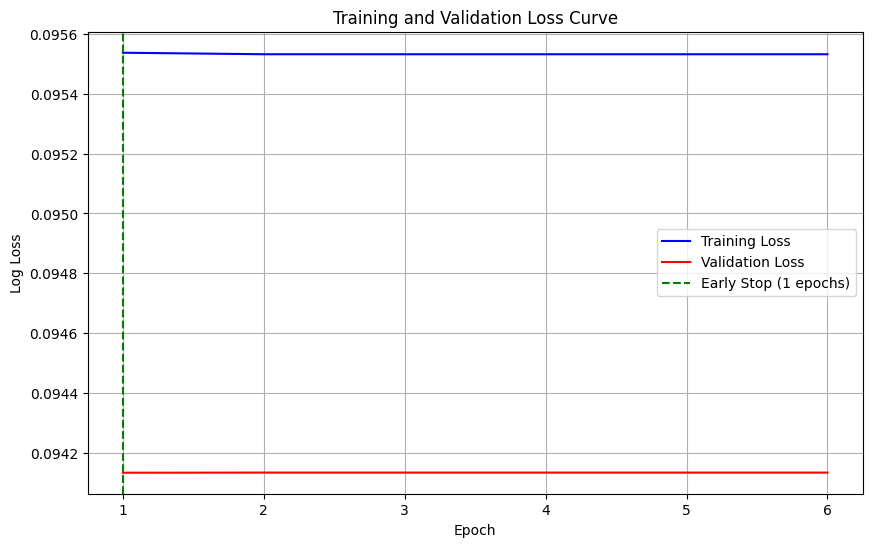

In [21]:
## Loss Curve (Train vs. Validation)
epochs = range(1, len(training_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss', color='b')
plt.plot(epochs, validation_losses, label='Validation Loss', color='r')
plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Early Stop ({best_epoch} epochs)')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
## Accuracy
accuracy = accuracy_score(y_test, y_pred_bin)
print(f"Test Set Accuracy: {accuracy:.4f}")

Test Set Accuracy: 0.9640


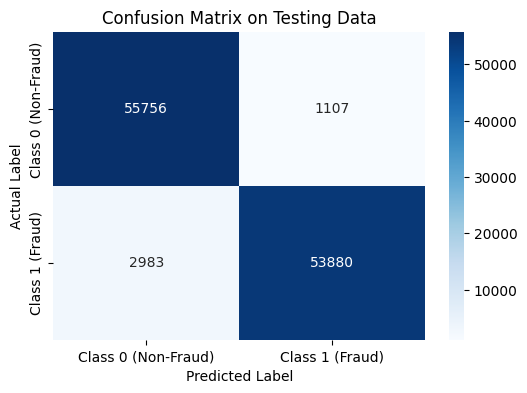

In [23]:
## Confusion Matrix
cm = confusion_matrix(y_test, y_pred_bin)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0 (Non-Fraud)', 'Class 1 (Fraud)'], yticklabels=['Class 0 (Non-Fraud)', 'Class 1 (Fraud)'])
plt.title('Confusion Matrix on Testing Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

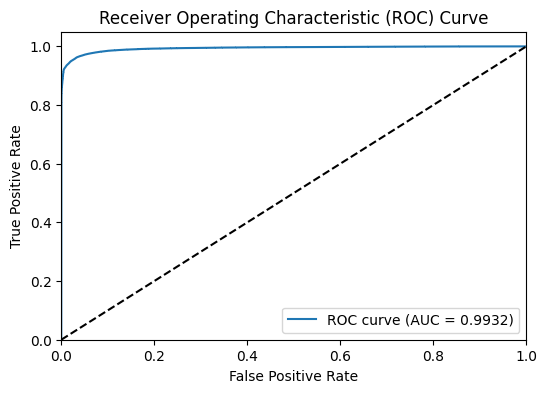

In [24]:
## ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()